In [1]:
from estimators import classifier, regressor
import numpy as np
import matplotlib.pyplot as plt

## Regression

In [2]:
def make_data(n_sample=1200,nc=30):
    limit=int(n_sample*2/3)# use 1/3 for training and 2/3 for testing
    X=np.random.uniform(-3,3,size=[n_sample,1])
    y=10*X.reshape(-1)+np.random.normal(size=n_sample)+20
    
    Xtrain=X[limit:]
    ytrain=y[limit:]

    Xtest=X[:limit]
    ytest=y[:limit]
    #Outliers
    perm=np.random.permutation(n_sample-limit)
    if nc != 0:
        Xtrain[perm[-nc:]]=(0.1*(np.random.randn(nc))+np.array([24])).reshape(nc,1)
        ytrain[perm[-nc:]]=0.1*(np.random.randn(nc))+np.array([24])

    return Xtrain,ytrain,Xtest,ytest

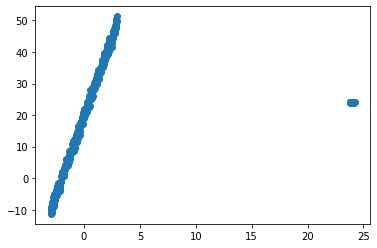

In [3]:
Xtrain,ytrain,Xtest,ytest=make_data()
plt.scatter(Xtrain,ytrain)

### Test of our algorithm VS sklearn

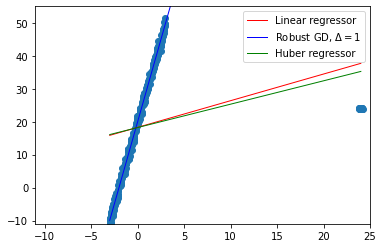

In [7]:
from sklearn.linear_model import LinearRegression,HuberRegressor
reg=LinearRegression()
hreg=HuberRegressor()

from sklearn import preprocessing
reg.fit(Xtrain,ytrain)
line_X = np.arange(Xtrain.min(), Xtrain.max())[:, np.newaxis]
line_y = reg.predict(line_X)

hreg.fit(Xtrain,ytrain)
hline_X = np.arange(Xtrain.min(), Xtrain.max())[:, np.newaxis]
hline_y = hreg.predict(line_X)

hom_c1=regressor(K=91,eta0=0.1,Delta=1,beta=0) # eta0 is linked to the step-size, beta is the risge penalisation parameter (here no penalization)
hom_c1.fit(Xtrain,ytrain)
line_yh_c1 = hom_c1.predict(line_X)

plt.scatter(Xtrain,ytrain)
plt.plot(line_X, line_y, color='red', linewidth=1, label='Linear regressor')
plt.plot(line_X, line_yh_c1, color='blue', linewidth=1, label='Robust GD, $\Delta=1$')
plt.plot(hline_X, hline_y, color='green', linewidth=1, label='Huber regressor')
plt.xlim(-11,25)
plt.ylim(-11,55)
plt.legend()

### Monte Carlo study: role of k and Delta

In [5]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn import clone
from joblib import Parallel, delayed
def score(clf,M=100,N=900,nc=30):
    res=[]
    for f in range(M):
        clf2=clone(clf)
        Xtrain,ytrain,Xtest,ytest=make_data(n_sample=N,nc=nc)
        clf2.fit(Xtrain,ytrain)
        res+=[mean_squared_error(clf2.predict(Xtest),ytest)]
    return res
def score_param(clf,param_name,param,M,N,nc):
    clf2=clone(clf)
    clf2.set_params(**{param_name: param})
    return score(clf2,M,N,nc)
def scores(clf,param_name,param_range,M=50,N=900,nc=30):
    res=Parallel(n_jobs=10,verbose=1)(delayed(score_param)(clf,param_name,param,M,N,nc) for param in param_range)
    return res

### As k changes

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  6.4min finished


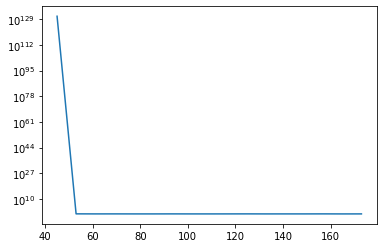

In [6]:
clf = regressor(eta0=0.1)
result = scores(clf,'K', np.arange(21,180,8), M=10, N=900,nc=30)
plt.semilogy(np.arange(21,180,8),np.median(result, axis=1))

### As Delta changes

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  2.4min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  3.0min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  4.2min finished


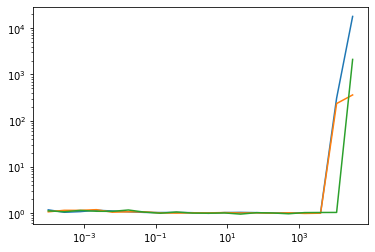

In [10]:
for K in [61,91,151]:
    clf = regressor(K=K,eta0=.1)
    result = scores(clf,'Delta', np.logspace(-4,4.5,num=20), M=10, N=900,nc=30)
    plt.loglog(np.logspace(-4,4.5,num=20),np.median(result, axis=1), label='K='+str(K))

## Classification

In [11]:
from sklearn import datasets
np.random.seed(41)
centers = [-np.ones(2), np.ones(2)]

Xtrain, ytrain = datasets.make_blobs(n_samples=600, n_features=2, cluster_std=1.4,
                  centers=centers, shuffle=True)
for f in range(30):
    ind=int(np.floor(np.random.rand()*len(Xtrain)))
    Xtrain=np.vstack([Xtrain[:ind],(0.1*(np.random.randn(2))+np.array([24,8])).reshape(1,2),Xtrain[ind:]])
    ytrain=np.hstack([ytrain[:ind],[0],ytrain[ind:]])


<ipython-input-12-c2d8ea658bdc>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
<ipython-input-12-c2d8ea658bdc>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


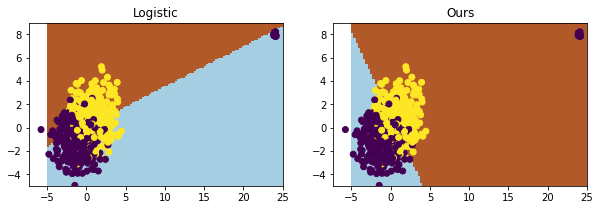

In [12]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
clf = classifier(K=91, Delta=0.01, eta0=30, epochs=300)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)# LR plot
lr.fit(Xtrain,ytrain)

xx, yy= np.meshgrid(np.linspace(-5, 25, num=100), np.linspace(-5, 9,num=100))
Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


plt.scatter(Xtrain[:,0],Xtrain[:,1],c=ytrain)
plt.title('Logistic')
plt.subplot(1,2,2)# Our plot
clf.fit(Xtrain,ytrain)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


plt.scatter(Xtrain[:,0],Xtrain[:,1],c=ytrain)
plt.title('Ours')
plt.show()

In [16]:
from sklearn import datasets

def make_classif_data(N=100,Nt=1000,Nc=3, rng=None):
    if rng is None:
        rng = np.random.RandomState()
    X,y = datasets.make_moons(n_samples=N, noise=0.2, random_state=rng)

    perm=rng.permutation(N)
    if Nc != 0:
        X[perm[-Nc:]]=np.vstack([np.zeros(Nc),5*np.ones(Nc)]).T
        y[perm[-Nc:]]=1


    Xtest,ytest = datasets.make_moons(n_samples=Nt, noise=0.1,random_state=rng)
    return X,y,Xtest,ytest
Xtrain,ytrain,Xtest,ytest=make_classif_data(N=100, Nc=10)

<ipython-input-14-0477b65defa6>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
/home/frost/tmpmath/excess_risk/Excess-risk-bounds-in-robust-empirical-risk-minimization/estimators.py:109: RuntimeWarning: overflow encountered in exp
  pertes=np.log(1+np.exp(-x.dot(w)*y))
/home/frost/tmpmath/excess_risk/Excess-risk-bounds-in-robust-empirical-risk-minimization/estimators.py:106: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
<ipython-input-14-0477b65defa6>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto

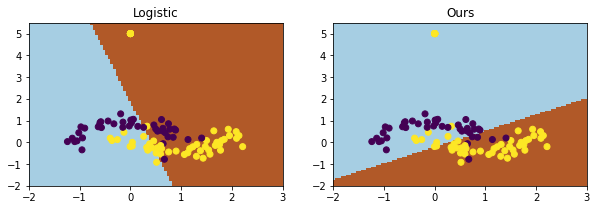

In [14]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
clf = classifier(K=51, Delta=0.01, eta0=30, epochs=300)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)# LR plot
lr.fit(Xtrain,ytrain)

xx, yy= np.meshgrid(np.linspace(-2, 3, num=100), np.linspace(-2, 5.5,num=100))
Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


plt.scatter(Xtrain[:,0],Xtrain[:,1],c=ytrain)
plt.title('Logistic')
plt.subplot(1,2,2)# Our plot
clf.fit(Xtrain,ytrain)

xx, yy= np.meshgrid(np.linspace(-2, 3, num=100), np.linspace(-2, 5.5,num=100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


plt.scatter(Xtrain[:,0],Xtrain[:,1],c=ytrain)
plt.title('Ours')
plt.show()

In [17]:

def one_iteration(clf,N,Nt,Nc,r):
    rng = np.random.RandomState(r)
    X,y,Xt,yt=make_classif_data(N,Nt,Nc,rng)
    clf2=clone(clf)
    clf2.fit(X,y)
    return np.mean(clf2.predict(Xt)==yt)

def score(clf,N=100,Nt=1000,M=300,Nc=3):
    res=Parallel(n_jobs=8)(delayed(one_iteration)(clf,N,Nt,Nc,f+int(100*np.random.uniform())) for f in np.arange(M))
    return res

Ks=np.arange(3,80,10)
from tqdm import tqdm
resmom=[]
reshom=[]

for K in tqdm(Ks):
    clfmom=classifier(K=int(K),Delta=0,eta0=10,beta=0, shuffle=True,)
    clfhom=classifier(K=int(K),Delta=0.01,eta0=10,beta=0, shuffle=True)
    reshom+=[score(clfhom,100,10000,30,10)]
    resmom+=[score(clfmom,100,10000,30,10)]

100%|██████████| 8/8 [01:45<00:00, 13.15s/it]


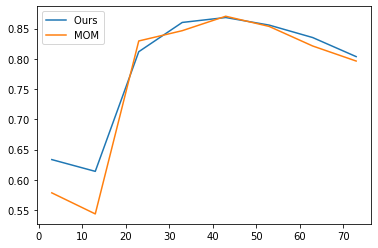

In [19]:
plt.plot(Ks, np.median(reshom, axis=1), label='Ours ')
plt.plot(Ks, np.median(resmom, axis=1), label='MOM')
plt.legend()